# 데이터 로드

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap
import random

random.seed(42)
np.random.seed(42)


plt.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False



In [66]:
df = pd.read_csv('data_2.csv', dtype={'isbn': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               3316 non-null   object 
 1   title              3316 non-null   object 
 2   publishDate        3316 non-null   int64  
 3   price              3316 non-null   int64  
 4   pageCount          3316 non-null   int64  
 5   size               3316 non-null   float64
 6   weight             3316 non-null   int64  
 7   label              3316 non-null   int64  
 8   author_name_tf     3316 non-null   int64  
 9   publisher_name_tf  3316 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 259.2+ KB


In [67]:
df.head()
df.describe()
df.isnull().sum()

isbn                 0
title                0
publishDate          0
price                0
pageCount            0
size                 0
weight               0
label                0
author_name_tf       0
publisher_name_tf    0
dtype: int64

In [68]:
# 두 CSV 파일 불러오기 (isbn을 문자열로 처리)
keyword_best = pd.read_csv('mecab keyword(베스트).csv', dtype={'isbn': str})
keyword_book = pd.read_csv('mecab keyword(일반).csv', dtype={'isbn': str})

# 컬럼 이름 확인
best_columns = keyword_best.columns.tolist()
book_columns = keyword_book.columns.tolist()

best_columns, book_columns


(['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'],
 ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'isbn'])

In [69]:
df_best = df[df['label'] == 1].copy()
df_book = df[df['label'] == 0].copy()

print("베스트셀러 수:", len(df_best))
print("일반 도서 수:", len(df_book))

베스트셀러 수: 1000
일반 도서 수: 2316


In [70]:
df_best = df_best.merge(keyword_best, on='isbn', how='left')
df_book = df_book.merge(keyword_book, on='isbn', how='left')


In [71]:
df = pd.concat([df_best, df_book], ignore_index=True)
print(df.shape)

(3316, 16)


In [72]:
df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.005781,0.003096,0.006070,0.005778,0.004806,0.974469
1,0.000781,0.644215,0.000820,0.151553,0.202110,0.000523
2,0.000660,0.000353,0.000693,0.706756,0.000548,0.290990
3,0.001478,0.993275,0.001552,0.001477,0.001229,0.000990
4,0.001208,0.000647,0.674994,0.321337,0.001004,0.000809


In [73]:
# for i in range(6):
#     df[f'topic_{i}'] = df[f'topic_{i}'].fillna(0)

# # 확인
# df[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].isnull().sum()


# 이상치

In [74]:
# numeric_cols = ['price', 'pageCount', 'size', 'weight']
# for col in numeric_cols:
#     sns.boxplot(x=df[col])
#     plt.title(f'{col} Boxplot')
#     plt.show()

In [75]:
# import numpy as np

# # size를 제외한 컬럼에 log1p 변환 적용
# df['price_log'] = np.log1p(df['price'])
# df['pageCount_log'] = np.log1p(df['pageCount'])
# df['weight_log'] = np.log1p(df['weight'])

# # 변환된 결과의 기술통계 확인
# log_transformed_stats = df[['price_log', 'pageCount_log', 'weight_log']].describe()
# log_transformed_stats


# XGB

In [76]:
X = df.drop(columns=['isbn', 'title', 'label'])  # 또는 title 제외 안 할 수도 있음
y = df['label']

In [77]:
from sklearn.model_selection import train_test_split

# 먼저 train (70%) vs temp (30%) 분할 (stratify 추가)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# temp (30%)을 다시 validation: test = 2:1 비율로 나눔 (stratify 추가)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

# 크기 확인
X_train.shape, X_val.shape, X_test.shape


((2321, 13), (663, 13), (332, 13))

In [90]:
non_nan_count = X_val['topic_0'].notna().sum()
print(f"Validation set에서 topic_0 값이 있는 샘플 개수: {non_nan_count}")

Validation set에서 topic_0 값이 있는 샘플 개수: 325


[I 2025-06-08 22:13:41,771] A new study created in memory with name: no-name-a40d5181-90b2-4f46-867b-c89f81338d09


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-08 22:13:42,011] Trial 0 finished with value: 0.951734539969834 and parameters: {'max_depth': 5, 'learning_rate': 0.1667521176194013, 'n_estimators': 800, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.951734539969834.
[I 2025-06-08 22:13:42,531] Trial 1 finished with value: 0.9622926093514329 and parameters: {'max_depth': 8, 'learning_rate': 0.005394455304087533, 'n_estimators': 1000, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.9622926093514329.
[I 2025-06-08 22:13:42,773] Trial 2 finished with value: 0.9547511312217195 and parameters: {'max_depth': 6, 'learning_rate': 0.014639847680621753, 'n_estimators': 700, 'subsample': 0.5

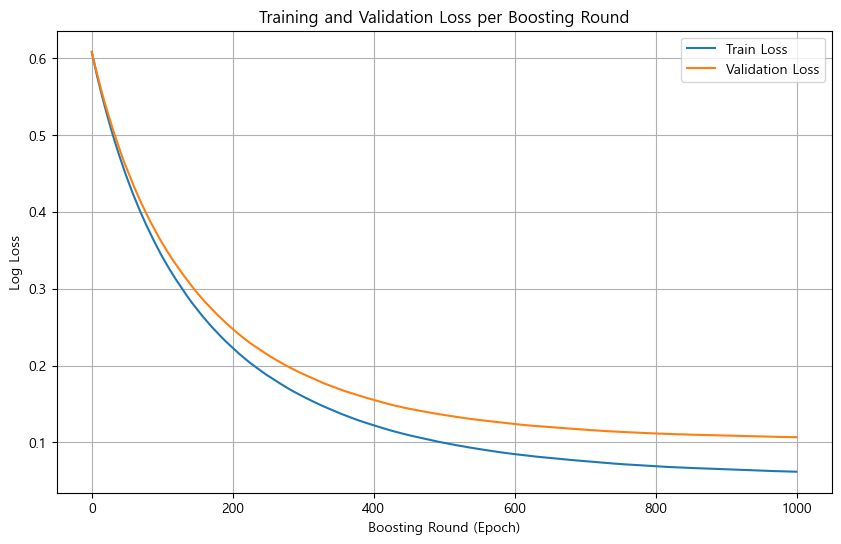


==== XGB_baseline ====
[[453  10]
 [ 14 186]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       463
           1       0.95      0.93      0.94       200

    accuracy                           0.96       663
   macro avg       0.96      0.95      0.96       663
weighted avg       0.96      0.96      0.96       663


==== XGB_optuna ====
[[454   9]
 [ 10 190]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       463
           1       0.95      0.95      0.95       200

    accuracy                           0.97       663
   macro avg       0.97      0.97      0.97       663
weighted avg       0.97      0.97      0.97       663

Best Params: {'max_depth': 10, 'learning_rate': 0.005302153977779674, 'n_estimators': 1000, 'subsample': 0.9609446284907329, 'colsample_bytree': 0.7281159932082892, 'gamma': 2.768077902198995, 'min_child_weight': 1, 'reg_alpha': 0.5732909776512292, 'reg_

In [99]:
import optuna
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ 기본 모델 (그대로 유지)
basic_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1)
basic_model.fit(X_train, y_train)
y_val_pred_basic = basic_model.predict(X_val)

results = []
results.append({
    'name': 'XGB_baseline',
    'model': basic_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_basic),
    'report': classification_report(y_val, y_val_pred_basic, output_dict=False)
})

# 2️⃣ Optuna 목적 함수 (넓은 파라미터 공간)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 4️⃣ 최적 모델로 학습 및 결과 저장
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=42)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=False
)
y_val_pred_tuned = best_model.predict(X_val)
eval_result = best_model.evals_result_
train_loss = eval_result['validation_0']['logloss']
val_loss = eval_result['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Boosting Round (Epoch)')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss per Boosting Round')
plt.legend()
plt.grid(True)
plt.show()

results.append({
    'name': 'XGB_optuna',
    'model': best_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_tuned),
    'report': classification_report(y_val, y_val_pred_tuned, output_dict=False),
    'best_params': best_params
})

# 5️⃣ 결과 출력
for res in results:
    print(f"\n==== {res['name']} ====")
    print(res['conf_matrix'])
    print(res['report'])
    if 'best_params' in res:
        print("Best Params:", res['best_params'])

In [100]:
print("Train Accuracy:", accuracy_score(y_train, best_model.predict(X_train)))
print("Val Accuracy:", accuracy_score(y_val, best_model.predict(X_val)))
print("Test Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

Train Accuracy: 0.990521327014218
Val Accuracy: 0.971342383107089
Test Accuracy: 0.9698795180722891


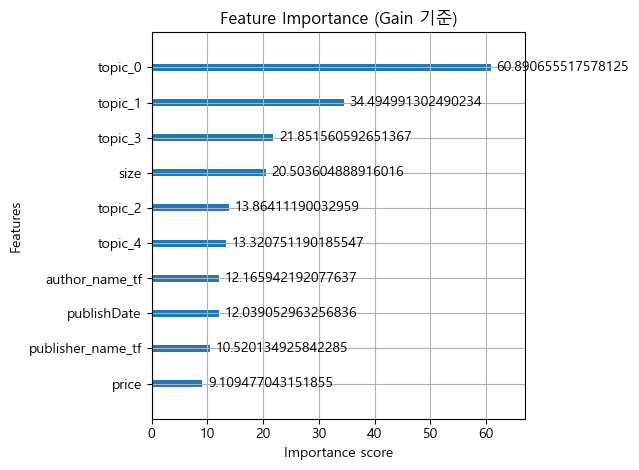

In [101]:
# 피처 중요도 시각화 (Gain 기준)
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Gain 기준)")
plt.tight_layout()
plt.show()

C:\Users\hc\AppData\Local\Temp\ipykernel_29104\501247281.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


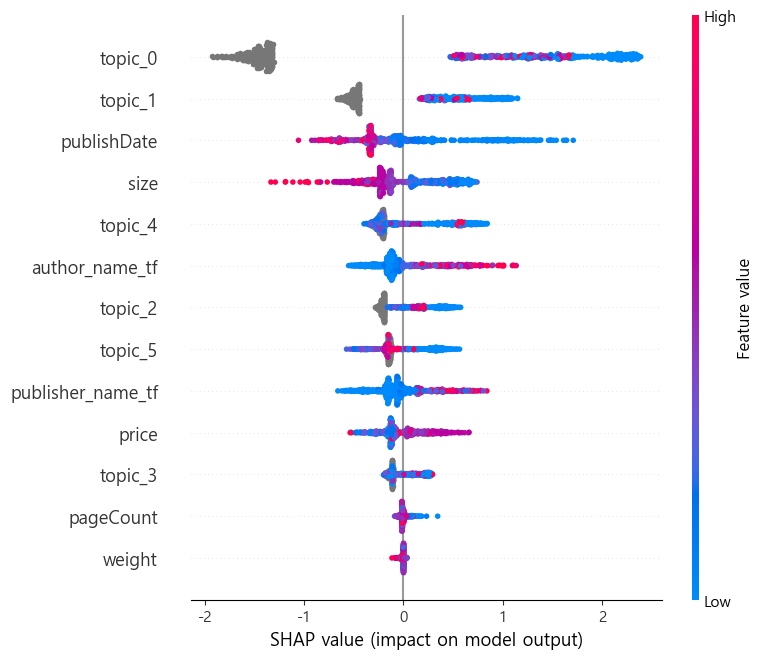

C:\Users\hc\AppData\Local\Temp\ipykernel_29104\501247281.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val, plot_type="bar")


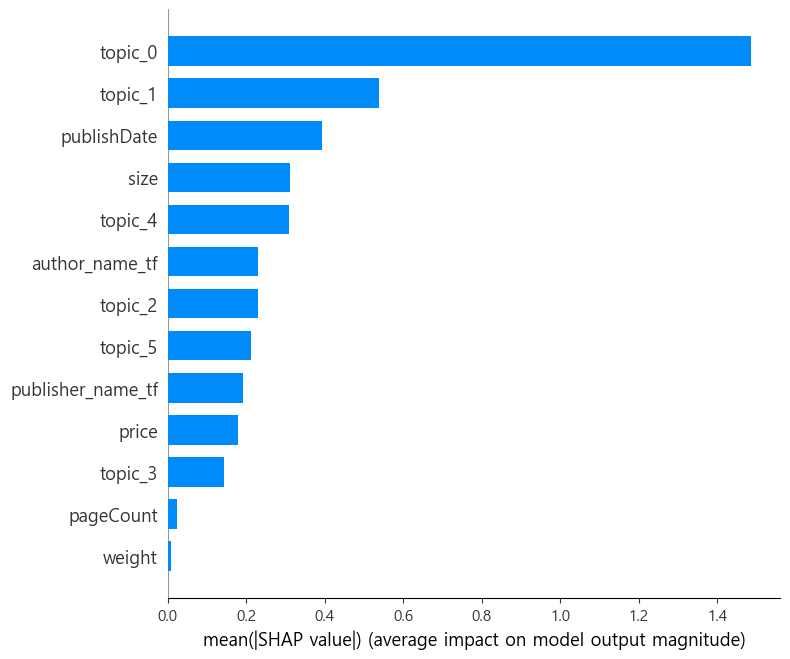

In [102]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(best_model, X_train)
shap_values = explainer(X_val)

# 요약 시각화 (Summary plot)
shap.summary_plot(shap_values, X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [103]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def evaluate_model_with_kfold(model, X, y, cv=5):
    """
    K-fold cross validation으로 모델 성능 평가
    """
    # Stratified K-fold (클래스 비율 유지)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # 각 지표별 점수 계산
    accuracy_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    precision_scores = cross_val_score(model, X, y, cv=skf, scoring='precision')
    recall_scores = cross_val_score(model, X, y, cv=skf, scoring='recall')
    
    # 결과 출력
    print(f"=== {cv}-Fold Cross Validation Results ===")
    print(f"Accuracy: {accuracy_scores.mean():.4f} (+/- {accuracy_scores.std() * 2:.4f})")
    print(f"F1-Score: {f1_scores.mean():.4f} (+/- {f1_scores.std() * 2:.4f})")
    print(f"Precision: {precision_scores.mean():.4f} (+/- {precision_scores.std() * 2:.4f})")
    print(f"Recall: {recall_scores.mean():.4f} (+/- {recall_scores.std() * 2:.4f})")
    
    # 각 fold별 상세 결과
    print("\n=== Fold별 상세 결과 ===")
    for i, (acc, f1, prec, rec) in enumerate(zip(accuracy_scores, f1_scores, precision_scores, recall_scores)):
        print(f"Fold {i+1}: Acc={acc:.4f}, F1={f1:.4f}, Prec={prec:.4f}, Rec={rec:.4f}")
    
    return {
        'accuracy': accuracy_scores,
        'f1': f1_scores,
        'precision': precision_scores,
        'recall': recall_scores
    }

# 사용 예시 (기존 모델에 적용)
cv_results = evaluate_model_with_kfold(best_model, X, y, cv=5)


=== 5-Fold Cross Validation Results ===
Accuracy: 0.9581 (+/- 0.0149)
F1-Score: 0.9309 (+/- 0.0255)
Precision: 0.9244 (+/- 0.0259)
Recall: 0.9380 (+/- 0.0512)

=== Fold별 상세 결과 ===
Fold 1: Acc=0.9699, F1=0.9515, Prec=0.9245, Rec=0.9800
Fold 2: Acc=0.9532, F1=0.9238, Prec=0.9082, Rec=0.9400
Fold 3: Acc=0.9517, F1=0.9184, Prec=0.9375, Rec=0.9000
Fold 4: Acc=0.9517, F1=0.9208, Prec=0.9118, Rec=0.9300
Fold 5: Acc=0.9638, F1=0.9400, Prec=0.9400, Rec=0.9400


# 이런저런

In [104]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # CSV 불러오기
# df = pd.read_csv('mecab keyword(일반).csv')

# # 토픽 컬럼
# topic_cols = [f'topic_{i}' for i in range(6)]

# # 시각화용 그림 생성
# plt.figure(figsize=(18, 10))

# # 각 topic별 히스토그램
# for idx, col in enumerate(topic_cols, 1):
#     filtered = df[df[col] <= 0.005]
#     plt.subplot(2, 3, idx)
#     plt.hist(filtered[col], bins=30, edgecolor='black')
#     plt.title(f'{col} (≤ 0.005)')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.grid(True)

# plt.tight_layout()
# plt.show()



In [105]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 파일 경로
# file_path = "mecab keyword(베스트).csv"

# # 데이터 불러오기
# df_best = pd.read_csv(file_path)

# # topic 컬럼 리스트
# topic_cols = [f'topic_{i}' for i in range(6)]

# plt.figure(figsize=(15, 10))
# for i, col in enumerate(topic_cols, 1):
#     plt.subplot(2, 3, i)
#     ax = sns.histplot(df_best[col], kde=True, bins=30)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')

#     # 각 막대 위에 빈도수 텍스트 표시
#     for patch in ax.patches:
#         height = patch.get_height()
#         if height > 0:
#             plt.text(
#                 patch.get_x() + patch.get_width() / 2,
#                 height,
#                 f'{int(height)}',
#                 ha='center',
#                 va='bottom',
#                 fontsize=8
#             )

# plt.tight_layout()
# plt.show()

